In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD ,AdamW

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json
from statistics import mean

In [2]:
import utils_generic as generic
import multitask_dep as mt
import model_confs as confs
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tasks = ['to','as','about']

In [4]:
model_conf = confs.bert_conf
encoding_type = 'relative'

# Datos ConvAI

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = mt.Vocabulary(data['train'],encoding_type)

convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [7]:
convai_train_dataset = mt.DatasetMultitaskDep(convai_train_token,tasks,eval=False)
convai_val_dataset = mt.DatasetMultitaskDep(convai_val_token,tasks,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 
md_dataset = mt.DatasetMultitaskDep(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [10]:
dl_train =DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_val =DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_eval = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=mt.collate_fn)

# Modelo multitask

In [11]:
num_epochs = 100
learning_rate = 1e-6

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0495766800039736 	 Validation loss: 2.0060414621385476 	 
  1%|          | 574/57400 [02:05<2:32:29,  6.21it/s]
Epoch 2 	 Training loss: 1.993028396513404 	 Validation loss: 1.9921048374499304 	 
  2%|▏         | 1148/57400 [03:50<3:04:20,  5.09it/s]
Epoch 3 	 Training loss: 1.9765430821774312 	 Validation loss: 1.9789548688015695 	 
  3%|▎         | 1722/57400 [05:37<2:44:52,  5.63it/s]
Epoch 4 	 Training loss: 1.9718826413154602 	 Validation loss: 1.9738539558345989 	 
  4%|▍         | 2296/57400 [07:25<2:46:59,  5.50it/s]
Epoch 5 	 Training loss: 1.9658162728834652 	 Validation loss: 1.9807675915249323 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [09:12<2:35:15,  5.85it/s]
Epoch 6 	 Training loss: 1.9645903459409388 	 Validation loss: 1.9717152644011935 	 
  6%|▌         | 3444/57400 [10:58<2:20:42,  6.39it/s]
Epoch 7 	 Training loss: 1.9578169067146887 	 Validation loss: 1.9720347877276145 	 

1 epoch without improvement
  7%|▋         | 40

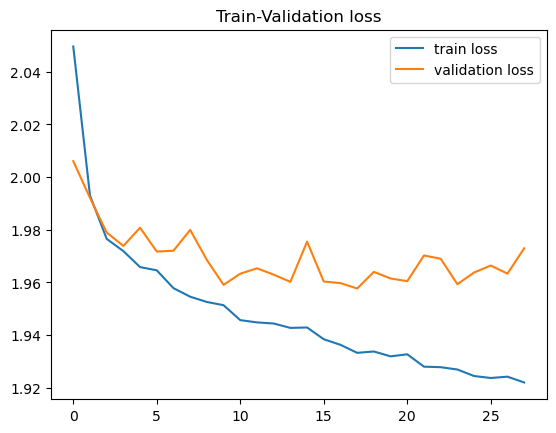

In [12]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='bert_multitask_relative_1'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [13]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6982323232323232, 'precision': 0.6982323232323232, 'f1': 0.6982323232323232, 'accuracy': 0.6982323232323232}, 'as': {'recall': 0.7301173402868318, 'precision': 0.7301173402868318, 'f1': 0.7301173402868318, 'accuracy': 0.7301173402868318}, 'about': {'recall': 0.8329081632653061, 'precision': 0.8329081632653061, 'f1': 0.8329081632653061, 'accuracy': 0.8329081632653061}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7396593673965937, 'precision': 0.7396593673965937, 'f1': 0.7396593673965937, 'accuracy': 0.7396593673965937}, 'as': {'recall': 0.7424242424242424, 'precision': 0.7424242424242424, 'f1': 0.7424242424242424, 'accuracy': 0.7424242424242424}, 'about': {'recall': 0.8489583333333334, 'precision': 0.8489583333333334, 'f1': 0.8489583333333334, 'accuracy': 0.8489583333333334}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6535433070866141, 'precision': 0.6535433070866141, 'f1': 0.6535433070866141, 'accuracy': 0.6535433070866141}, 'a

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.057423519963587 	 Validation loss: 2.0187154705241577 	 
  1%|          | 574/57400 [01:41<2:58:44,  5.30it/s]
Epoch 2 	 Training loss: 1.9981672107550326 	 Validation loss: 1.991065007145122 	 
  2%|▏         | 1148/57400 [03:23<2:31:54,  6.17it/s]
Epoch 3 	 Training loss: 1.9784790653384936 	 Validation loss: 1.987537747722561 	 
  3%|▎         | 1722/57400 [05:04<2:35:57,  5.95it/s]
Epoch 4 	 Training loss: 1.9706692595930464 	 Validation loss: 1.9806280903897042 	 
  4%|▍         | 2296/57400 [06:46<2:31:08,  6.08it/s]
Epoch 5 	 Training loss: 1.9653853666076262 	 Validation loss: 1.9693499258009053 	 
  5%|▌         | 2870/57400 [08:28<2:15:53,  6.69it/s]
Epoch 6 	 Training loss: 1.9586598941673385 	 Validation loss: 1.9739824109158273 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [10:09<2:28:17,  6.06it/s]
Epoch 7 	 Training loss: 1.9594409862461821 	 Validation loss: 1.9705188213768652 	 

2 epoch without improvement
  7%|▋         | 4018

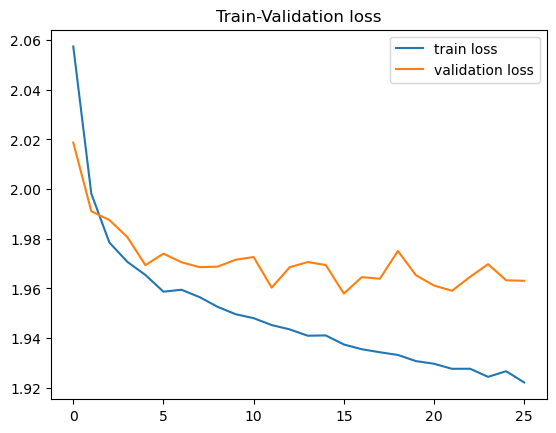

In [14]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='bert_multitask_relative_2'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [15]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.7095959595959596, 'precision': 0.7095959595959596, 'f1': 0.7095959595959596, 'accuracy': 0.7095959595959596}, 'as': {'recall': 0.7327249022164276, 'precision': 0.7327249022164276, 'f1': 0.7327249022164276, 'accuracy': 0.7327249022164276}, 'about': {'recall': 0.8431122448979592, 'precision': 0.8431122448979592, 'f1': 0.8431122448979592, 'accuracy': 0.8431122448979592}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7347931873479319, 'precision': 0.7347931873479319, 'f1': 0.7347931873479319, 'accuracy': 0.7347931873479319}, 'as': {'recall': 0.7348484848484849, 'precision': 0.7348484848484849, 'f1': 0.7348484848484848, 'accuracy': 0.7348484848484849}, 'about': {'recall': 0.8489583333333334, 'precision': 0.8489583333333334, 'f1': 0.8489583333333334, 'accuracy': 0.8489583333333334}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6824146981627297, 'precision': 0.6824146981627297, 'f1': 0.6824146981627297, 'accuracy': 0.6824146981627297}, 'a

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0611723032147213 	 Validation loss: 2.0202784780728615 	 
  1%|          | 574/57400 [01:42<3:08:42,  5.02it/s]
Epoch 2 	 Training loss: 1.9965764998558921 	 Validation loss: 1.998553884231438 	 
  2%|▏         | 1148/57400 [03:23<2:31:26,  6.19it/s]
Epoch 3 	 Training loss: 1.9769480629249732 	 Validation loss: 1.984355540598853 	 
  3%|▎         | 1722/57400 [05:05<2:30:30,  6.17it/s]
Epoch 4 	 Training loss: 1.9712147588098505 	 Validation loss: 1.9740098997697992 	 
  4%|▍         | 2296/57400 [06:47<2:20:48,  6.52it/s]
Epoch 5 	 Training loss: 1.9663401185843172 	 Validation loss: 1.9722146907095182 	 
  5%|▌         | 2870/57400 [08:29<2:29:33,  6.08it/s]
Epoch 6 	 Training loss: 1.9621330306505076 	 Validation loss: 1.9730464543326427 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [10:11<2:49:52,  5.29it/s]
Epoch 7 	 Training loss: 1.957878549547561 	 Validation loss: 1.9722226938958896 	 

2 epoch without improvement
  7%|▋         | 4018

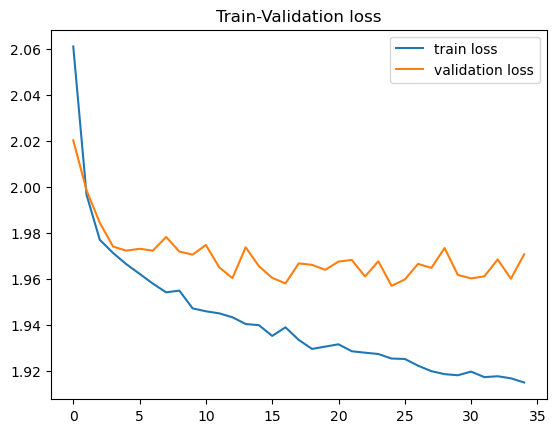

In [16]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='bert_multitask_relative_3'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [17]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6982323232323232, 'precision': 0.6982323232323232, 'f1': 0.6982323232323232, 'accuracy': 0.6982323232323232}, 'as': {'recall': 0.727509778357236, 'precision': 0.727509778357236, 'f1': 0.727509778357236, 'accuracy': 0.727509778357236}, 'about': {'recall': 0.8316326530612245, 'precision': 0.8316326530612245, 'f1': 0.8316326530612244, 'accuracy': 0.8316326530612245}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7347931873479319, 'precision': 0.7347931873479319, 'f1': 0.7347931873479319, 'accuracy': 0.7347931873479319}, 'as': {'recall': 0.7449494949494949, 'precision': 0.7449494949494949, 'f1': 0.7449494949494948, 'accuracy': 0.7449494949494949}, 'about': {'recall': 0.84375, 'precision': 0.84375, 'f1': 0.84375, 'accuracy': 0.84375}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6587926509186351, 'precision': 0.6587926509186351, 'f1': 0.6587926509186351, 'accuracy': 0.6587926509186351}, 'as': {'recall': 0.7088948787061995, 'precision': 

In [18]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.8358843537414966, 'precision': 0.8358843537414966, 'f1': 0.8358843537414966, 'accuracy': 0.8358843537414966}
Métricas etiqueta male: {'recall': 0.8472222222222222, 'precision': 0.8472222222222222, 'f1': 0.8472222222222222, 'accuracy': 0.8472222222222222}
Métricas etiqueta female:  {'recall': 0.825, 'precision': 0.825, 'f1': 0.825, 'accuracy': 0.825}

 to
Resultado global: {'recall': 0.702020202020202, 'precision': 0.702020202020202, 'f1': 0.702020202020202, 'accuracy': 0.702020202020202}
Métricas etiqueta male: {'recall': 0.7364152473641524, 'precision': 0.7364152473641524, 'f1': 0.7364152473641524, 'accuracy': 0.7364152473641524}
Métricas etiqueta female:  {'recall': 0.6649168853893264, 'precision': 0.6649168853893264, 'f1': 0.6649168853893264, 'accuracy': 0.6649168853893264}

 as
Resultado global: {'recall': 0.7301173402868318, 'precision': 0.7301173402868318, 'f1': 0.7301173402868318, 'accuracy': 0.7301173402868318}
Métrica